In [1]:
! wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip

import shutil
shutil.unpack_archive("bank+marketing.zip", ".")
shutil.unpack_archive("bank.zip", ".")

--2024-10-14 19:24:56--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
CA-Zertifikat »/etc/ssl/certs/ca-certificates.crt« wurde geladen
Auflösen des Hostnamens archive.ics.uci.edu (archive.ics.uci.edu)… 128.195.10.252
Verbindungsaufbau zu archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443 … verbunden.
HTTP-Anforderung gesendet, auf Antwort wird gewartet … 200 OK
Länge: nicht spezifiziert
Wird in »bank+marketing.zip« gespeichert.

bank+marketing.zip      [    <=>             ] 999,85K  1,07MB/s    in 0,9s    

2024-10-14 19:24:58 (1,07 MB/s) - »bank+marketing.zip« gespeichert [1023843]



In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
df = pd.read_csv("bank-full.csv", sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
features = [
    'age',
    'job',
    'marital',
    'education',
    'balance',
    'housing',
    'contact',
    'day',
    'month',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'poutcome',
    'y'
]
df = df[features]
df.info() # no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   balance    45211 non-null  int64 
 5   housing    45211 non-null  object
 6   contact    45211 non-null  object
 7   day        45211 non-null  int64 
 8   month      45211 non-null  object
 9   duration   45211 non-null  int64 
 10  campaign   45211 non-null  int64 
 11  pdays      45211 non-null  int64 
 12  previous   45211 non-null  int64 
 13  poutcome   45211 non-null  object
 14  y          45211 non-null  object
dtypes: int64(7), object(8)
memory usage: 5.2+ MB


## Target encoding

    Now we want to encode the y variable.
    Let's replace the values yes/no with 1/0.

In [5]:
y = df.y.map({"yes": 1, "no": 0})
df = df.drop("y", axis=1)
y.value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

## Split the data

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

# Question 1: ROC AUC feature importance

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

numerical_columns = X_train.select_dtypes(exclude=['object']).columns

def feature_importance(X, y=y_train):
    model = LogisticRegression(random_state=1)
    model.fit(X, y)
    y_probs = model.predict_proba(X)[:, 1]
    return roc_auc_score(y_train, y_probs)

roc_per_feature = [feature_importance(X_train[[feature]]) for feature in numerical_columns] 
pd.DataFrame(data=dict(Feature=numerical_columns, ROC_AUC=roc_per_feature)).sort_values('ROC_AUC')    

,Feature,ROC_AUC
0,age,0.487814
2,day,0.525958
4,campaign,0.571454
1,balance,0.588831
5,pdays,0.590128
6,previous,0.598565
3,duration,0.814700


In [8]:
feature_importance(-X_train[['age']])

np.float64(0.48781428247265596)

# Question 2: Training the model

In [9]:
from sklearn.feature_extraction import DictVectorizer

X = X_train.to_dict(orient='records')
# Apply DictVectorizer to perform one-hot encoding
dv = DictVectorizer(sparse=False)
X = dv.fit_transform(X)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X, y_train)

# Make predictions and calculate the AUC on the validation set
X = X_val.to_dict(orient='records')
X = dv.transform(X)
y_pred_prob = model.predict_proba(X)[:, 1]
auc = roc_auc_score(y_val, y_pred_prob)

print(f"The AUC is {auc:.3}")

The AUC is 0.9


# Question 3: Precision and Recall

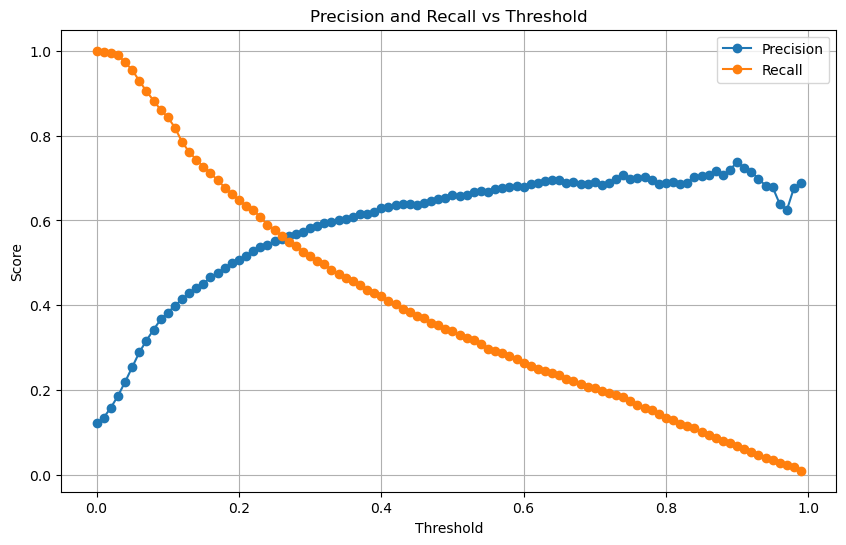

In [10]:
from sklearn.metrics import precision_score, recall_score

# Define thresholds from 0.0 to 1.0 with a step of 0.01
thresholds = np.arange(0.0, 1.0, 0.01)

precision_values = []
recall_values = []
# For each threshold, compute precision and recall
for threshold in thresholds:
    y_pred_threshold = (y_pred_prob >= threshold).astype(int)
    precision_values.append(precision_score(y_val, y_pred_threshold))
    recall_values.append(recall_score(y_val, y_pred_threshold))

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_values, label='Precision', linestyle='-', marker='o')
plt.plot(thresholds, recall_values, label='Recall', linestyle='-', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Question 4: F1 score

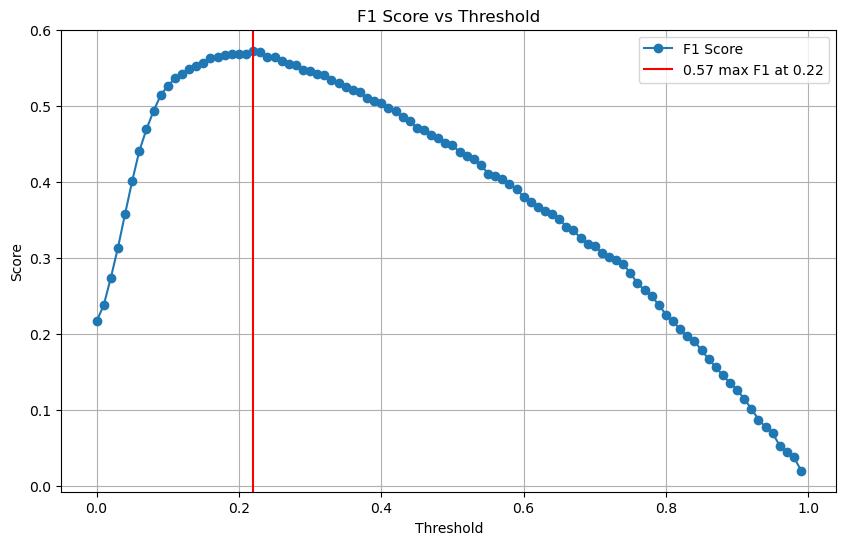

In [11]:
P = np.array(precision_values)
R = np.array(recall_values)
f1_scores = 2 * P * R / (P + R)
idx = f1_scores.argmax()
f1_max = f1_scores[idx]
threshold_max = thresholds[idx]
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score', linestyle='-', marker='o')
plt.axvline(x=threshold_max, label=f"{f1_max:.2} max F1 at {threshold_max}", color='r')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('F1 Score vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Question 5: 5-Fold CV

In [12]:
from sklearn.model_selection import KFold

def train_eval_logistic_regression(X, y, C=1.0) -> list[float]:
    kf = KFold(n_splits=5, shuffle=True, random_state=1)
    auc_per_fold = []
    
    for train_index, val_index in kf.split(X):
        X_train, X_val, y_train, y_val = X.iloc[train_index], X.iloc[val_index], y.iloc[train_index], y.iloc[val_index]
        X_train = X_train.to_dict(orient='records')
        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(X_train)
        
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train, y_train)
        
        # Make predictions and calculate the AUC on the validation set
        X_val = X_val.to_dict(orient='records')
        X_val = dv.transform(X_val)
        
        y_pred_prob = model.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred_prob)
        auc_per_fold.append(auc)
        
    return auc_per_fold

auc_per_fold = train_eval_logistic_regression(df, y)
auc_per_fold

[np.float64(0.9069509630450453),
 np.float64(0.8989261029741773),
 np.float64(0.9055266745586685),
 np.float64(0.9124494732828068),
 np.float64(0.9067924338924525)]

In [13]:
auc_per_fold = np.array(auc_per_fold)
auc_per_fold.std()

np.float64(0.004319922955648932)

# Question 6: Hyperparameter Tuning

In [14]:
param_C_candiates = [0.000001, 0.001, 1]

mean_score_per_C = []
std_per_C = []
for C in param_C_candiates:
    auc_per_fold = train_eval_logistic_regression(df, y, C=C)
    auc_per_fold = np.array(auc_per_fold)
    mean_score_per_C.append(round(auc_per_fold.mean(), 3))
    std_per_C.append(round(auc_per_fold.std(), 3))

pd.DataFrame(data=dict(C=param_C_candiates, mean=mean_score_per_C, std=std_per_C)).sort_values("mean")

,C,mean,std
0,0.000001,0.705,0.011
1,0.001000,0.868,0.006
2,1.000000,0.906,0.004
